In [197]:
import pandas as pd
import numpy as np 
import folium
import keplergl as kp
import geopandas as gpd
import networkx as nx
import osmnx as ox
import openrouteservice as ors
import branca.colormap as cm
import matplotlib.pyplot as plt
import multiprocessing as mp

from gtfs_functions import Feed
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon

#https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb
# https://github.com/GIScience/openrouteservice-py/blob/master/examples/basic_example.ipynb

ox.__version__

'2.0.0'

In [8]:
feed = Feed("transit_cleaned.zip")
feed_routes = feed.routes
feed_trips = feed.trips
feed_stops = feed.stops
feed_stop_times = feed.stop_times
feed_shapes = feed.shapes
feed_lines_freq = feed.lines_freq

INFO:root:Reading "routes.txt".
INFO:root:accessing trips
INFO:root:Start date is None. You should either specify a start date or set busiest_date to True.
INFO:root:Reading "trips.txt".
INFO:root:Reading "calendar.txt".
INFO:root:Reading "calendar_dates.txt".
INFO:root:The busiest date/s of this feed or your selected date range is/are:  ['2024-12-26'] with 43046 trips.
INFO:root:In the case that more than one busiest date was found, the first one will be considered.
INFO:root:In this case is 2024-12-26.
INFO:root:Reading "stop_times.txt".
INFO:root:_trips is defined in stop_times
INFO:root:Reading "stops.txt".
INFO:root:computing patterns
INFO:root:Reading "shapes.txt".


In [258]:
coords = feed_stops[['stop_lon', 'stop_lat']].values.tolist()
feed_stops['coords'] = pd.Series(coords)

indexes=[1, 2, 679, 3450, 7894]
test = np.array(coords)[indexes]
test = test.tolist()
test

[[-123.09149, 49.179962],
 [-123.091448, 49.18267],
 [-123.108805, 49.242588],
 [-122.981061, 49.271944],
 [-123.14597, 49.334271]]

Making the isochrone map using OpenRouteService, following this example https://github.com/GIScience/openrouteservice-py/blob/master/examples/basic_example.ipynb


In [260]:
map = folium.Map(location=[49.25073221957535, -123.00896884483716], tiles = "CartoDB.Positron", zoom_start=11) 

In [262]:
api_key = '5b3ce3597851110001cf6248159f2d494f9c4c5aad2f9e8cfc9fe5bd'

client = ors.Client(key=api_key)

isochrone = client.isochrones(profile='foot-walking',
                              locations=test,
                              range=[1500],
                              interval=300)

folium.GeoJson(isochrone).add_to(map)

In [9]:
# isochrone

In [264]:
map

Not sure how to deal with the overlapping isochrones 

In [267]:
# df = pd.json_normalize(isochrone)

In [115]:
# isochrone

In [71]:
kepler_iso = kp.KeplerGl(height=400, data={"Transit Accessiblity": isochrone})
# kepler_iso.add_data(data=feed_stops, name="Stops")
kepler_iso.save_to_html(file_name="kepler_iso.html")

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to kepler_iso.html!


In [73]:
points = feed_stops[['stop_lon', 'stop_lat']]

In [75]:
# points

In [73]:
# feed_lines_freq.sort_values('min_per_trip')

In [134]:
# feed_stops

Creating the isochrone map using OSMnx and NetworkX, following this example https://github.com/gboeing/osmnx-examples/blob/main/notebooks/13-isolines-isochrones.ipynb

In [27]:
# configure the place, network type, trip times, and travel speed
place = 'Vancouver, Canada'
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [29]:
G = ox.graph_from_place(place, network_type=network_type)

In [30]:
gdf_nodes = ox.graph_to_gdfs(G, edges=False)
x, y = gdf_nodes['geometry'].unary_union.centroid.xy
center_node = ox.nearest_nodes(G, x[0], y[0])
node_list = ox.nearest_nodes(G, feed_stops['stop_lon'], feed_stops['stop_lat'])
G = ox.project_graph(G)

In [31]:
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [32]:
iso_colors = ox.plot.get_colors(n=len(trip_times), cmap='viridis', start=0)

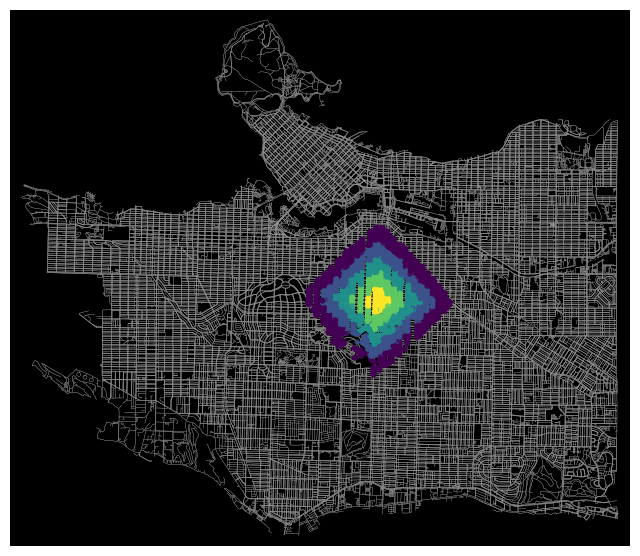

In [33]:
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [15 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                        bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

In [247]:
# test_nodes = [8169342396, 1315815926, 5989199551, 9168562896, 368902221, 3677464216, 256953813, 6852837652, 11544944847, 255435612, 251629093, 8143513995]

In [212]:
def isochrone_nodes(node):

    node_colors = {}
    
    for point in node_list:
        for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
            subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time')
            for node in subgraph.nodes():
                node_colors[node] = color
        nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
        ns = [15 if node in node_colors else 0 for node in G.nodes()]

    return nc, ns

Trying to use multiprocessing here to speed up the code https://github.com/gboeing/osmnx-examples/blob/v0.16.0/notebooks/02-routing-speed-time.ipynb

In [230]:
# cpus = mp.cpu_count() - 1 

# nc = []
# ns = []
# pool = mp.Pool(cpus)

# sma = pool.starmap_async(isochrone_nodes, node_list[0:24])

In [254]:
# test = sma.get()
node_list.size

8789

This test map took 30 seconds to create with 100 nodes, so it will take a while to do all 8789

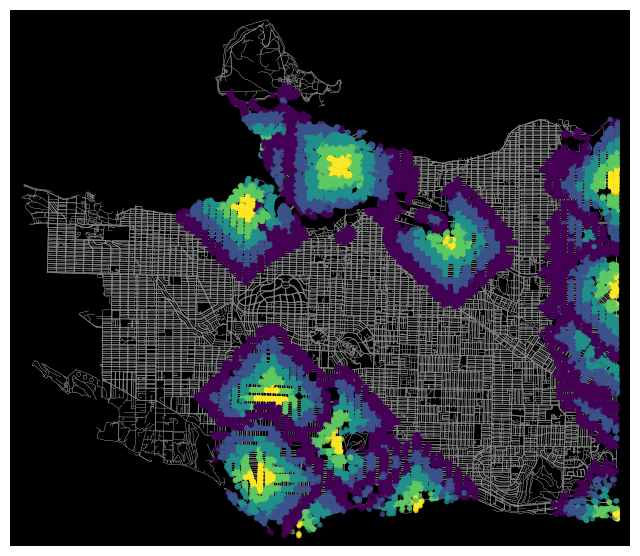

In [251]:
node_colors = {}

for point in node_list[0:100]:
    for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
        subgraph = nx.ego_graph(G, point, radius=trip_time, distance='time')
        for node in subgraph.nodes():
            node_colors[node] = color
    nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
    ns = [15 if node in node_colors else 0 for node in G.nodes()]

fig, ax = ox.plot_graph(G, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2,
                            bgcolor='k', edge_linewidth=0.2, edge_color='#999999')

Not sure how to deal with overlapping isochrones